In [1]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba', 'statsmodels']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy import stats
from numba import njit
import os

### Setting the random seed for reproducibility
np.random.seed(42)

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

In [2]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

# Volatility timing

We will now do volatility timing of the factors. We will do almost the same thing as in `20_volatility_managed_factors.ipynb`, but we will use volatility and not variance. We will first use the market variance to time all factors, and then use the individual factors volatility.

So, firstly:

$$r_{k,t+1}^\sigma=\frac{c}{\sigma_{mkt,t}} r_{k,t+1}$$

In [3]:
### Creating volatility timed factors using only the market volatility
volatility_timed_factors_mkt = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=volatility.columns)
c.loc['c', :] = np.nan

for factor in volatility.columns:
    def obj_func(c):
        vol_timed = (c / volatility['VW'].shift(1)) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m[factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c', factor] = res.x[0]

### Calculating the volatility timed factors
for factor in volatility_timed_factors_mkt.columns:
    volatility_timed_factors_mkt[factor] = c.loc['c', factor] / volatility['VW'].shift(1) * factor_ret_m[factor]

### Print
print(c)
print(f"Diff in std: {round(volatility_timed_factors_mkt.std() - factor_ret_m.std()).sum()}")

     SMB    HML    UMD     EW     VW    BAB
c 0.1696 0.1711 0.1514 0.1610 0.1557 0.1473
Diff in std: 0.0


Secondly:

$$r_{k,t+1}^\sigma=\frac{c}{\sigma_{k,t}} r_{k,t+1}$$

In [4]:
### Creating volatility timed factors using only the market volatility
volatility_timed_factors_fac = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

### Calculating the optimal c for each factor
c = pd.DataFrame(columns=volatility.columns)
c.loc['c', :] = np.nan

for factor in volatility.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor].shift(1)) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m[factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c', factor] = res.x[0]

### Calculating the volatility timed factors
for factor in volatility_timed_factors_fac.columns:
    volatility_timed_factors_fac[factor] = c.loc['c', factor] / volatility[factor].shift(1) * factor_ret_m[factor]

### Print
print(c)
print(f"Diff in std: {round(volatility_timed_factors_fac.std() - factor_ret_m.std()).sum()}")

     SMB    HML    UMD     EW     VW    BAB
c 0.1419 0.1507 0.1860 0.1411 0.1557 0.1893
Diff in std: 0.0


*Note:* The value of $c$ for $VW$ is equal in both scenarios, and the reutrns will also be identical by construction.

# Mean-variance optimazation

We will now use the data in the 120 last months to pick weights for three portfolios. The three portfolios are:

 - Uncondtional Mean-Variance portfolio (UMV): The mean-variance portfolio for a invstor only investing in the orginal factors.
 - Contional Mean-Variance portfolio using factor volatility ($CMV_{fac}$): The mean-variance portfolio for a invstor  investing in the orginal factors and the volatility-managed, based on it's own past volatility, version of the factor. 
 - Contional Mean-Variance portfolio using factor volatility ($CMV_{mkt}$): The mean-variance portfolio for a invstor  investing in the orginal factors and the volatility-managed, based on the market's past volatility, version of the factor. 

In [5]:
### Combining the factor returns
factor_ext_fac = pd.concat([factor_ret_m, volatility_timed_factors_fac], axis=1)
factor_ext_mkt = pd.concat([factor_ret_m, volatility_timed_factors_mkt], axis=1)

### Adding _vol to the last 6 columns
factor_ext_fac.columns = [col + '_org' for col in factor_ext_fac.columns[:-6]] + [col + '_vol' for col in factor_ext_fac.columns[-6:]]
factor_ext_mkt.columns = [col + '_org' for col in factor_ext_mkt.columns[:-6]] + [col + '_vol' for col in factor_ext_mkt.columns[-6:]]

### Creating a dataframe to store the portfolios in
MV = pd.DataFrame(index=factor_ext_fac.index, columns=['CMV_fac', 'CMV_mkt', 'UMV'])

### Creating a place to store the weights in to see what is going on
weights_org = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
weights_fac = pd.DataFrame(index=factor_ext_fac.index, columns=factor_ext_fac.columns)
weights_mkt = pd.DataFrame(index=factor_ext_mkt.index, columns=factor_ext_mkt.columns)

### Running the loop for mean-variance optimization
w = 120
for t in range(w, len(factor_ext_fac)):
    # Selecting the data for the last w months
    data_org = factor_ret_m.iloc[t-w:t]
    data_fac = factor_ext_fac.iloc[t-w:t]
    data_mkt = factor_ext_mkt.iloc[t-w:t]
    ret_org = factor_ret_m.iloc[t]
    ret_fac = factor_ext_fac.iloc[t]
    ret_mkt = factor_ext_mkt.iloc[t]

    # Getting the weights
    w_org = ptf_weights(data_org, negative=False, type = "MVP", gamma = 5)
    w_fac = ptf_weights(data_fac, negative=False, type = "MVP", gamma = 5)
    w_mkt = ptf_weights(data_mkt, negative=False, type = "MVP", gamma = 5)

    # Storing the weights
    weights_org.loc[factor_ret_m.index[t], :] = w_org
    weights_fac.loc[factor_ext_fac.index[t], :] = w_fac
    weights_mkt.loc[factor_ext_mkt.index[t], :] = w_mkt

    # Calculating the returns
    MV.loc[factor_ext_fac.index[t], 'UMV'] = np.dot(ret_org, w_org)
    MV.loc[factor_ext_fac.index[t], 'CMV_fac'] = np.dot(ret_fac, w_fac)
    MV.loc[factor_ext_fac.index[t], 'CMV_mkt'] = np.dot(ret_mkt, w_mkt)

### Removing rows with only NaN
MV = MV.dropna(how='all')

### Looking at the sharpe ratios
sharpes_ratio(MV)

CMV_fac   2.1988
CMV_mkt   2.2187
UMV       2.0164
dtype: object

In [6]:
### Getting the p-value of the sharpe ratio for CMV being bigger then UMV
n_boot = 100000
SR_diff_fac = []
SR_diff_mkt = []

### Running the loop
for i in range(n_boot):
    boot = stationary_bootstrap_multivariate(np.array(MV.astype(float)), 5, len(MV))
    SR_diff_fac.append(sharpes_ratio(boot[:,2]) - sharpes_ratio(boot[:,0]))
    SR_diff_mkt.append(sharpes_ratio(boot[:,2]) - sharpes_ratio(boot[:,1]))

### Calculating the p-value
p_value_fac = (np.sum(np.array(SR_diff_fac) > 0)) / (n_boot)
p_value_mkt = (np.sum(np.array(SR_diff_mkt) > 0)) / (n_boot)

### Printing
print('The p-value for the difference in Sharpe Ratios between CMV (using factor volatility) and UMV is:', p_value_fac)
print('The p-value for the difference in Sharpe Ratios between CMV (using market volatility) and UMV is:', p_value_mkt)

The p-value for the difference in Sharpe Ratios between CMV (using factor volatility) and UMV is: 0.09533
The p-value for the difference in Sharpe Ratios between CMV (using market volatility) and UMV is: 0.0107


In [7]:
### Getting the alphas
X = MV['UMV'].astype(float)
y = MV['CMV_fac'].astype(float)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
alpha_fac = model.params[0]
tstat_alpha_fac = model.tvalues[0]

y = MV['CMV_mkt'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
alpha_mkt = model.params[0]
tstat_alpha_mkt = model.tvalues[0]

In [8]:
### Creating a latex table
latex = pd.DataFrame(columns=['CMV_fac', 'CMV_mkt', 'UMV'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean() * 12
latex.loc['Standard deviation', :] = MV.std() * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV)
latex.loc['p-value', 'CMV_fac'] = p_value_fac
latex.loc['p-value', 'CMV_mkt'] = p_value_mkt
latex.loc['alpha', 'CMV_fac'] = alpha_fac * 12
latex.loc['alpha', 'CMV_mkt'] = alpha_mkt * 12
latex.loc['t(alpha)', 'CMV_fac'] = tstat_alpha_fac
latex.loc['t(alpha)', 'CMV_mkt'] = tstat_alpha_mkt

print(latex.to_latex(float_format="%.4f"))

\begin{tabular}{llll}
\toprule
 & CMV_fac & CMV_mkt & UMV \\
\midrule
Mean & 0.1978 & 0.1929 & 0.1846 \\
Standard deviation & 0.0900 & 0.0869 & 0.0916 \\
Sharpe ratio & 2.1988 & 2.2187 & 2.0164 \\
p-value & 0.0953 & 0.0107 & NaN \\
alpha & 0.0301 & 0.0274 & NaN \\
t(alpha) & 2.9010 & 4.4580 & NaN \\
\bottomrule
\end{tabular}



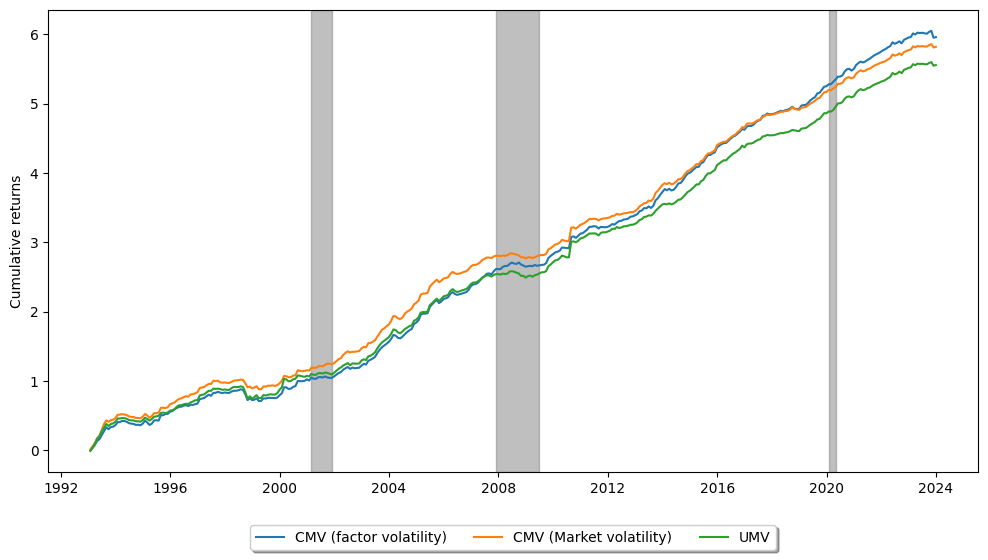

In [9]:
### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot(np.log(1 + MV.astype(float)).cumsum())
plt.ylabel('Cumulative returns')
plt.legend(["CMV (factor volatility)","CMV (Market volatility)","UMV"], loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=3)

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.savefig('Plots/cumulative_returns_ptfs.png')
plt.show()

In [10]:
### Storing the data
conn = sqlite3.connect('Data/data.db')

MV.to_sql('MV', conn, if_exists='replace')
volatility_timed_factors_mkt.to_sql('volatility_timed_factors_mkt', conn, if_exists='replace')
volatility_timed_factors_fac.to_sql('volatility_timed_factors_fac', conn, if_exists='replace')

conn.close()